In [1]:
# if no output is shown,
#   1. Open cmd or powershell terminal
#   2. Activate a conda environment running py 3.10.8+ (venv/conda optional but recommended)
#   3. cd to the directory containing THIS file, probably wherever you cloned the repo to. 
#   3. in your terminal run the following command(s): 
#       py -m pip install -r requirements.txt

#   If no errors, you should be able to run this file in a jupyter notebook or jupyter lab instance. End goal is to have a web app that can be run from a browser.. but that's a ways off.

#### TODO: remove collections from requirements.txt, it's not used in this file and throws an error when installing.

In [2]:
# General Imports
import numpy as np
import pandas as pd

# Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Warnings
import warnings
warnings.filterwarnings('ignore')

# Load                                                   ### REPLACE WITH GIT LINK -- CHECK BRANCH BEFORE RUNNING !!!###
# https://github.com/ttatum742/OSHAintern/blob/v0.1.2/data/reform.csv?raw=true
df = pd.read_csv('https://github.com/ttatum742/OSHAintern/blob/v0.1.2/data/reform.csv?raw=true')

In [3]:

## Specifying data pars
# df = df[df['State']=='TX']

# ## Processing
# # Drop Unwanted
# df.drop(["0","UPA","Address1","Address2","Inspection",
#          "Nature","Part of Body","Event","Source","Secondary Source"],axis=1,inplace=True)

# # Change Dtypes
# df.Hospitalized = df.Hospitalized.astype(int)
# df.Amputation= df.Amputation.fillna(0).astype(int)
df['EventDate'] = pd.to_datetime(df["EventDate"])

# Capitalize Category Values
for x in ["City","State"]:
    df[x] = df[x].str.capitalize()

# Clean Employer Variable
df["Employer"] = df["Employer"].str.capitalize().str.replace('[^\w\s]','')
df.loc[df.Employer.str.contains(r"(?i)Postal Service|(?i)States Postal|(?i)USPS"),"Employer"] = "US postal service"
df.loc[df.Employer.str.contains(r"\b(?i)ups\b"),"Employer"] = 'United parcel service'
# Remove company type from name.
df["Employer"] = df.Employer.str.replace(r"\binc\b|\bllc\b|\blde\b|\bco\b|\bcorp\b|\bllp\b", '').str.strip()

"""

Regular Expression Explanation:
- [^\w\s] : [^] Negatve Set \w Words \s White Spaces
- (?i)ups : Removes case sensitivity from ups -> UPS, UPs, ups etc. would be returned
- r"\bups\b" : In this case "ups" will only be returned if it borders (b) a non-letter. e.i its a exact word.
- | : Represents "or" argument


"""
# USE THE CODE BELOW TO MAKE AMPUTATION VARIABLE FROM EVENT DESC
# df["Amputation"] = df["EventDesc"].str.contains("amputation", case=False).astype(int)

# New Gender Variables
df["Male"] = False
df["Female"] = False

# True when gender pronoun appears
df.loc[df['Final Narrative'].str.contains(
    r'(?i)\\b|(?i)\bhe\b|(?i)\bmale\b|(?i)\bhim\b'),["Male"]] = True
df.loc[df['Final Narrative'].str.contains(
    r'(?i)\\b|(?i)\bshe\b|(?i)\bfemale\b|(?i)\bher\b'),["Female"]] = True

# Gender Var
df["Gender"] = "NULL"
df.loc[(df.Male == True),"Gender"] = "Male"
df.loc[(df.Female == True),"Gender"] = "Female"
df.loc[(df.Female == True)&(df.Male == True),"Gender"] = "Both Mentioned"


In [4]:

"""
Hospitalized/Amputated - Binary Variable

"""

# Fast funcdtion for top occruence categories
def topcat_index(series, n=5):
    """
    Returns the top n categories in a series
    """
    return series.value_counts().index[:n]
def topcats(series, n=5):
    return series.isin(topcat_index(series, n=n))


# ## New Amputation Variable
# df["Amputated"]= False
# df.loc[df["Amputation"] > 0,"Amputated"] = True

# # New Hospital
# df["Hospital"]= False
# df.loc[df["Hospitalized"] > 0,"Hospital"] = True

print("Pre-Processing Complete")



Pre-Processing Complete


In [5]:

for x in ["Male","Female","Gender"]:
    print("\n{}:\n".format(x))
    print(df[x].value_counts())
    print(df[x].value_counts(normalize=True))

print("\n{} % o both gender pronouns are precent".format(
    round((df[(df.Male == True) & (df.Female == True)].shape[0]/df.shape[0])*100,2)))


Male:

False    106477
True      18904
Name: Male, dtype: int64
False    0.849228
True     0.150772
Name: Male, dtype: float64

Female:

False    119537
True       5844
Name: Female, dtype: int64
False    0.95339
True     0.04661
Name: Female, dtype: float64

Gender:

NULL              100674
Male               18863
Female              5803
Both Mentioned        41
Name: Gender, dtype: int64
NULL              0.802945
Male              0.150445
Female            0.046283
Both Mentioned    0.000327
Name: Gender, dtype: float64

0.03 % o both gender pronouns are precent


In [6]:
def custom_describe(df):
    """
  
    """
    unique_count = []
    for x in df.columns:
        mode = df[x].mode().iloc[0]
        unique_count.append([x,
                             len(df[x].unique()),
                             df[x].isnull().sum(),
                             mode,
                             df[x][df[x]==mode].count(),
                             df[x].dtypes])
    print("Dataframe Dimension: {} Rows, {} Columns".format(*df.shape))
    return pd.DataFrame(unique_count, columns=["Column","Unique","Missing","Mode","Mode Occurence","dtype"]).set_index("Column").T

custom_describe(df)

Dataframe Dimension: 125381 Rows, 18 Columns


Column,Unnamed: 0,UPA,EventDate,EventTitle,Final Narrative,Part of Body Title,NatureTitle,SourceTitle,degree,City,State,Employer,Primary NAICS,Amputation,Hospitalized,Male,Female,Gender
Unique,125381,119775,45082,366,112076,155,213,1121,3,10779,108,80682,2412,1,1,2,2,4
Missing,0,0,0,0,0,0,0,0,0,16,0,0,2,0,0,0,0,0
Mode,0,201923414,2005-03-23 13:15:00,Struck By,Employee Is Injured in Fall from Ladder,Fingertip(s),Fractures,Machine,Hospitalized,Houston,Ca,US postal service,238160.0,0,0,False,False,NULL
Mode Occurence,1,104,135,12655,284,8634,23401,8004,83772,1603,22903,1160,1684,125381,125381,106477,119537,100674
dtype,int64,int64,datetime64[ns],object,object,object,object,object,object,object,object,object,object,int64,int64,bool,bool,object


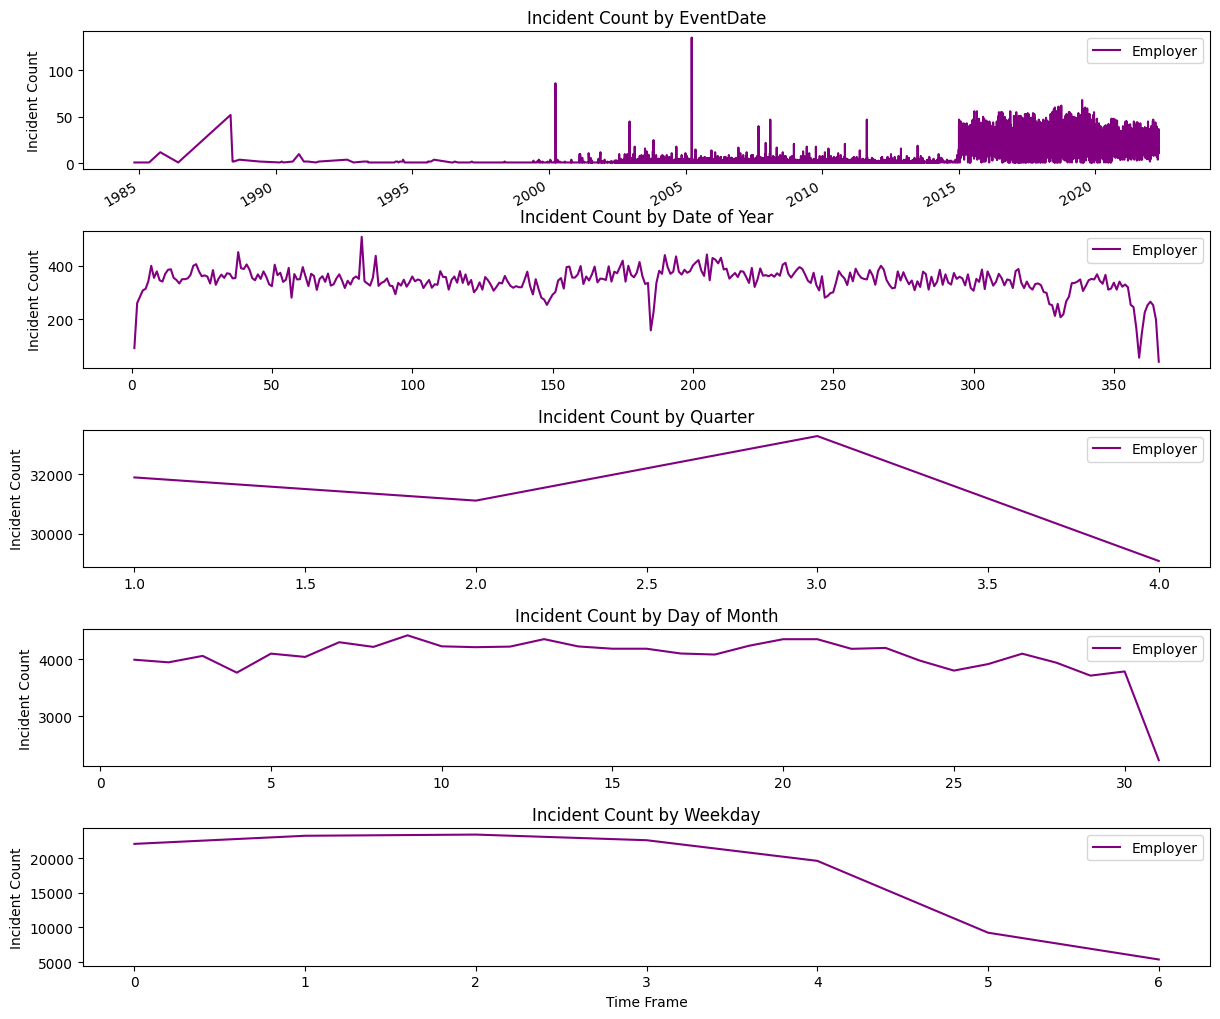

In [7]:
def time_slicer(df, timeframes):
    """
    Function to count observation occurrence through different lenses of time.
    """
    f, ax = plt.subplots(len(timeframes), figsize = [12,10])
    for i,x in enumerate(timeframes):
        df.loc[:,[x,"Employer"]].groupby([x]).count().plot(ax=ax[i],color="purple")
        ax[i].set_ylabel("Incident Count")
        ax[i].set_title("Incident Count by {}".format(x))
        ax[i].set_xlabel("")
    ax[len(timeframes)-1].set_xlabel("Time Frame")
    plt.tight_layout(pad=0)
    
# Time Frames of Interest
df["Date of Year"] = df['EventDate'].dt.dayofyear # Day of Year
df["Weekday"] = df['EventDate'].dt.weekday 
df["Quarter"] = df['EventDate'].dt.quarter
df["Day of Month"] = df['EventDate'].dt.day

# Plot
time_slicer(df=df,timeframes=["EventDate","Date of Year","Quarter","Day of Month","Weekday"])

In [8]:
# with sns.color_palette("viridis"):
#     f, ax = plt.subplots(1,2, figsize=[10,4],sharey=True)
#     sns.countplot(df["Hospitalized"],ax=ax[0])
#     ax[0].set_title("Distribution of Hospitalized")
#     ax[0].set_ylabel("Count")
#     sns.countplot(df["Amputation"],ax=ax[1])
#     ax[1].set_title("Distribution of Amputation")
#     ax[1].set_ylabel("")
#     plt.tight_layout(pad=0)

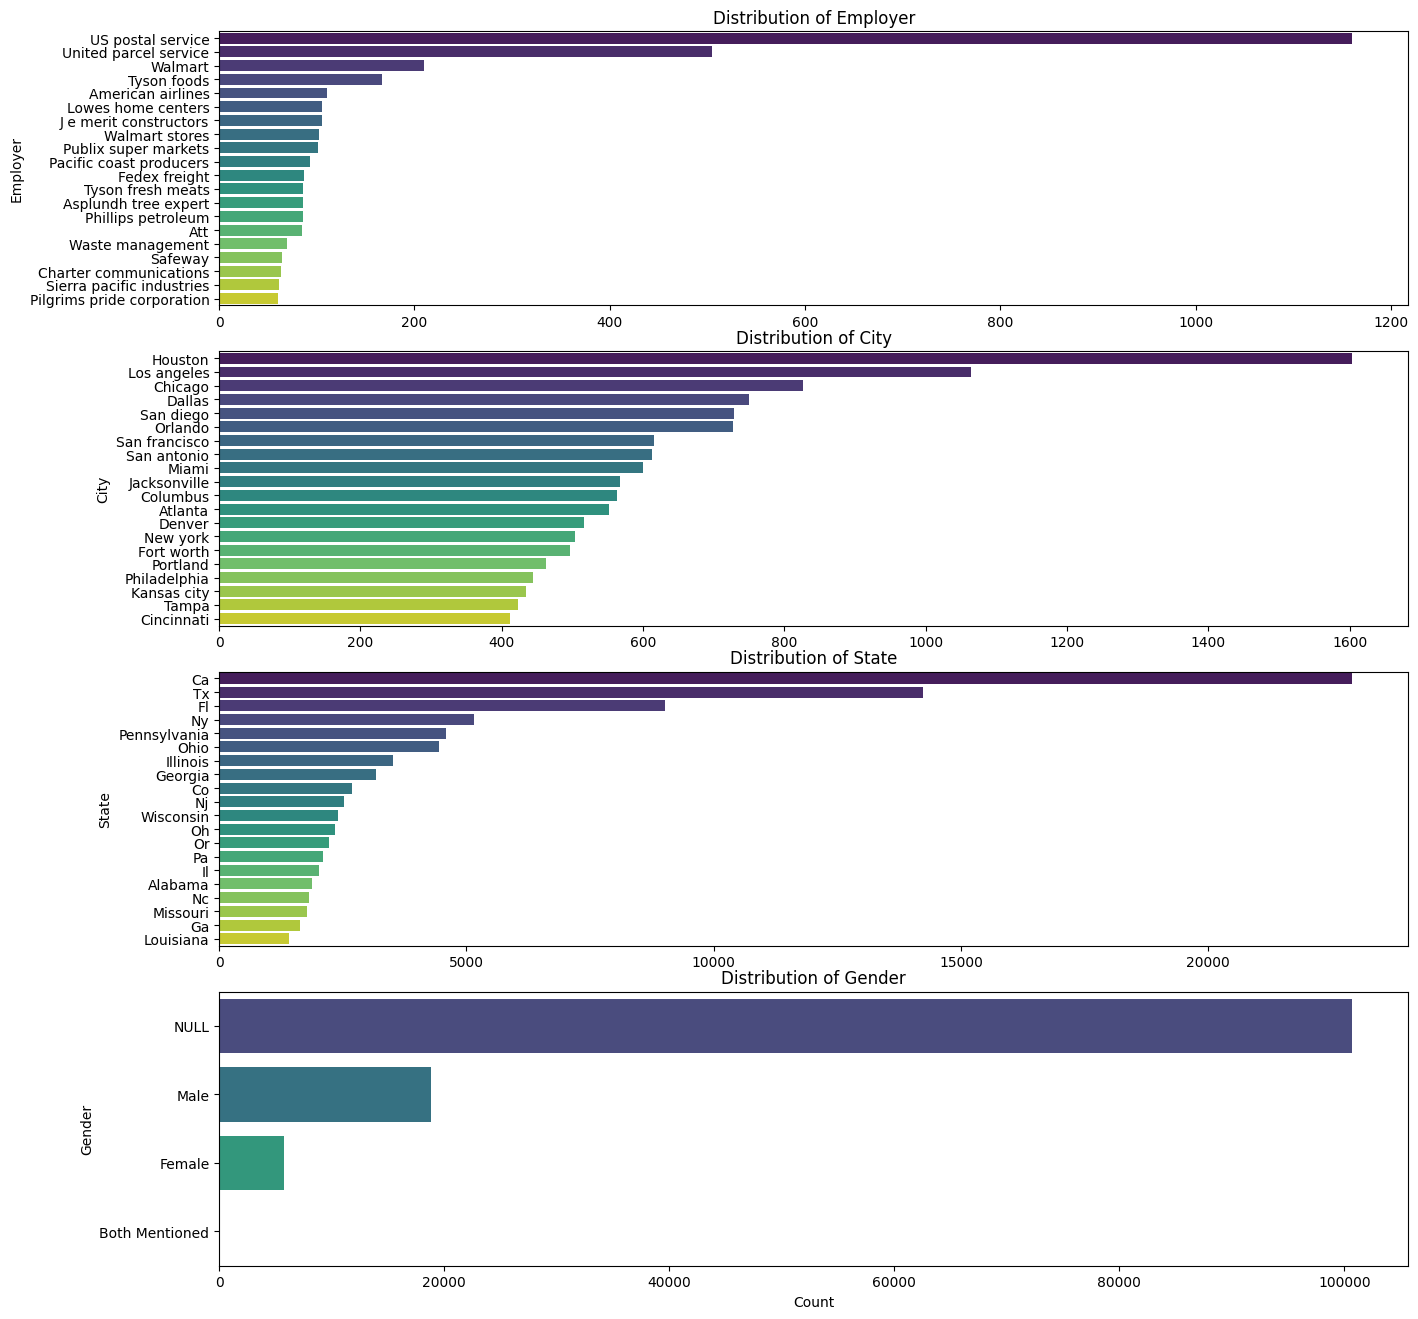

In [9]:
def cat_countplot(df, var, size = [8,10], n=15):
    """
    Function to plot multiple seaborn count plots horizontally, and ordered by most frequent class.
    """
    with sns.color_palette("inferno"):
        f, ax = plt.subplots(len(var),figsize=size)
        for i,x in enumerate(var):
            temptop = df[x].value_counts().index[:n]
            sns.countplot(y=df[x][df[x].isin(temptop)], order=temptop, ax=ax[i],palette='viridis')
            ax[i].set_title("Distribution of {}".format(x))
            ax[i].set_xlabel("")
        ax[len(var)-1].set_xlabel("Count")
        plt.tight_layout(pad=0)

def continous_plots(df, var):
    """
    Built this and found it doesn't apply to my problem at hand.
    """
    f, ax = plt.subplots(1,len(var),figsize=(12,4), sharey=False)
    for i,x in enumerate(var):
        sns.distplot(df[x], ax=ax[i])
        ax[i].set_title("{} Distribution".format(x))
        ax[i].set_ylabel("")
        ax[i].set_xlabel("Distribution")
    ax[0].set_ylabel("Density")
    plt.tight_layout()
    
# Plot
with sns.color_palette("inferno"):
    cat_countplot(df=df, var=["Employer","City","State", "Gender"],n=20, size=[14,13])

**Interpretation:** <br>
Texas and Florida are leaders of pack. Once again, would be best to scale for total laborers before making statements about the risk of these states.

I am quite surprised to find so many incidents occuring at the postal services USPS and UPS. 

Something that must be investigated are the incidents at Walt Disney World.
***
**NatureTitle and Source Title:** <br>

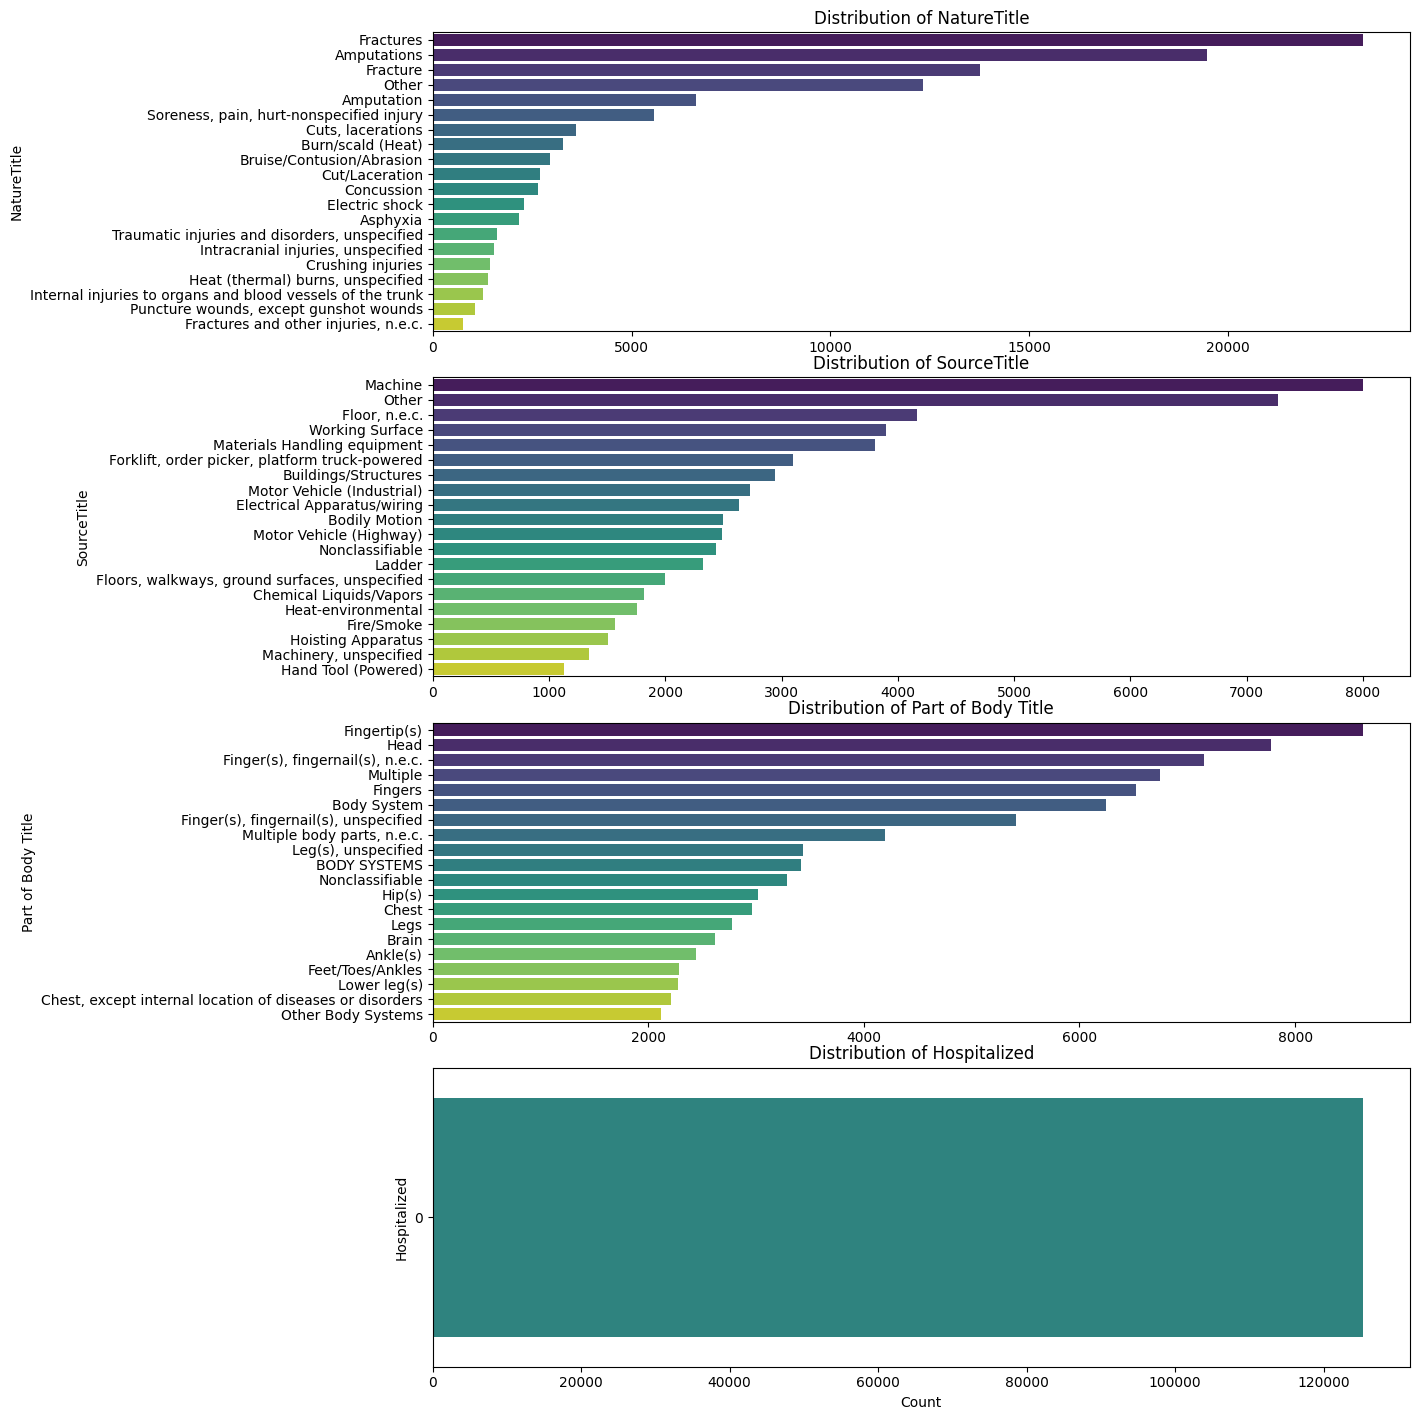

In [10]:
cat_countplot(df=df, var=["NatureTitle","SourceTitle","Part of Body Title","Hospitalized"],n=20,size=[14,14])

Need to find a way to consolidate terms like Fracture/Fractures, TX/texas, etc. Might just do this in excel to save frustration. 

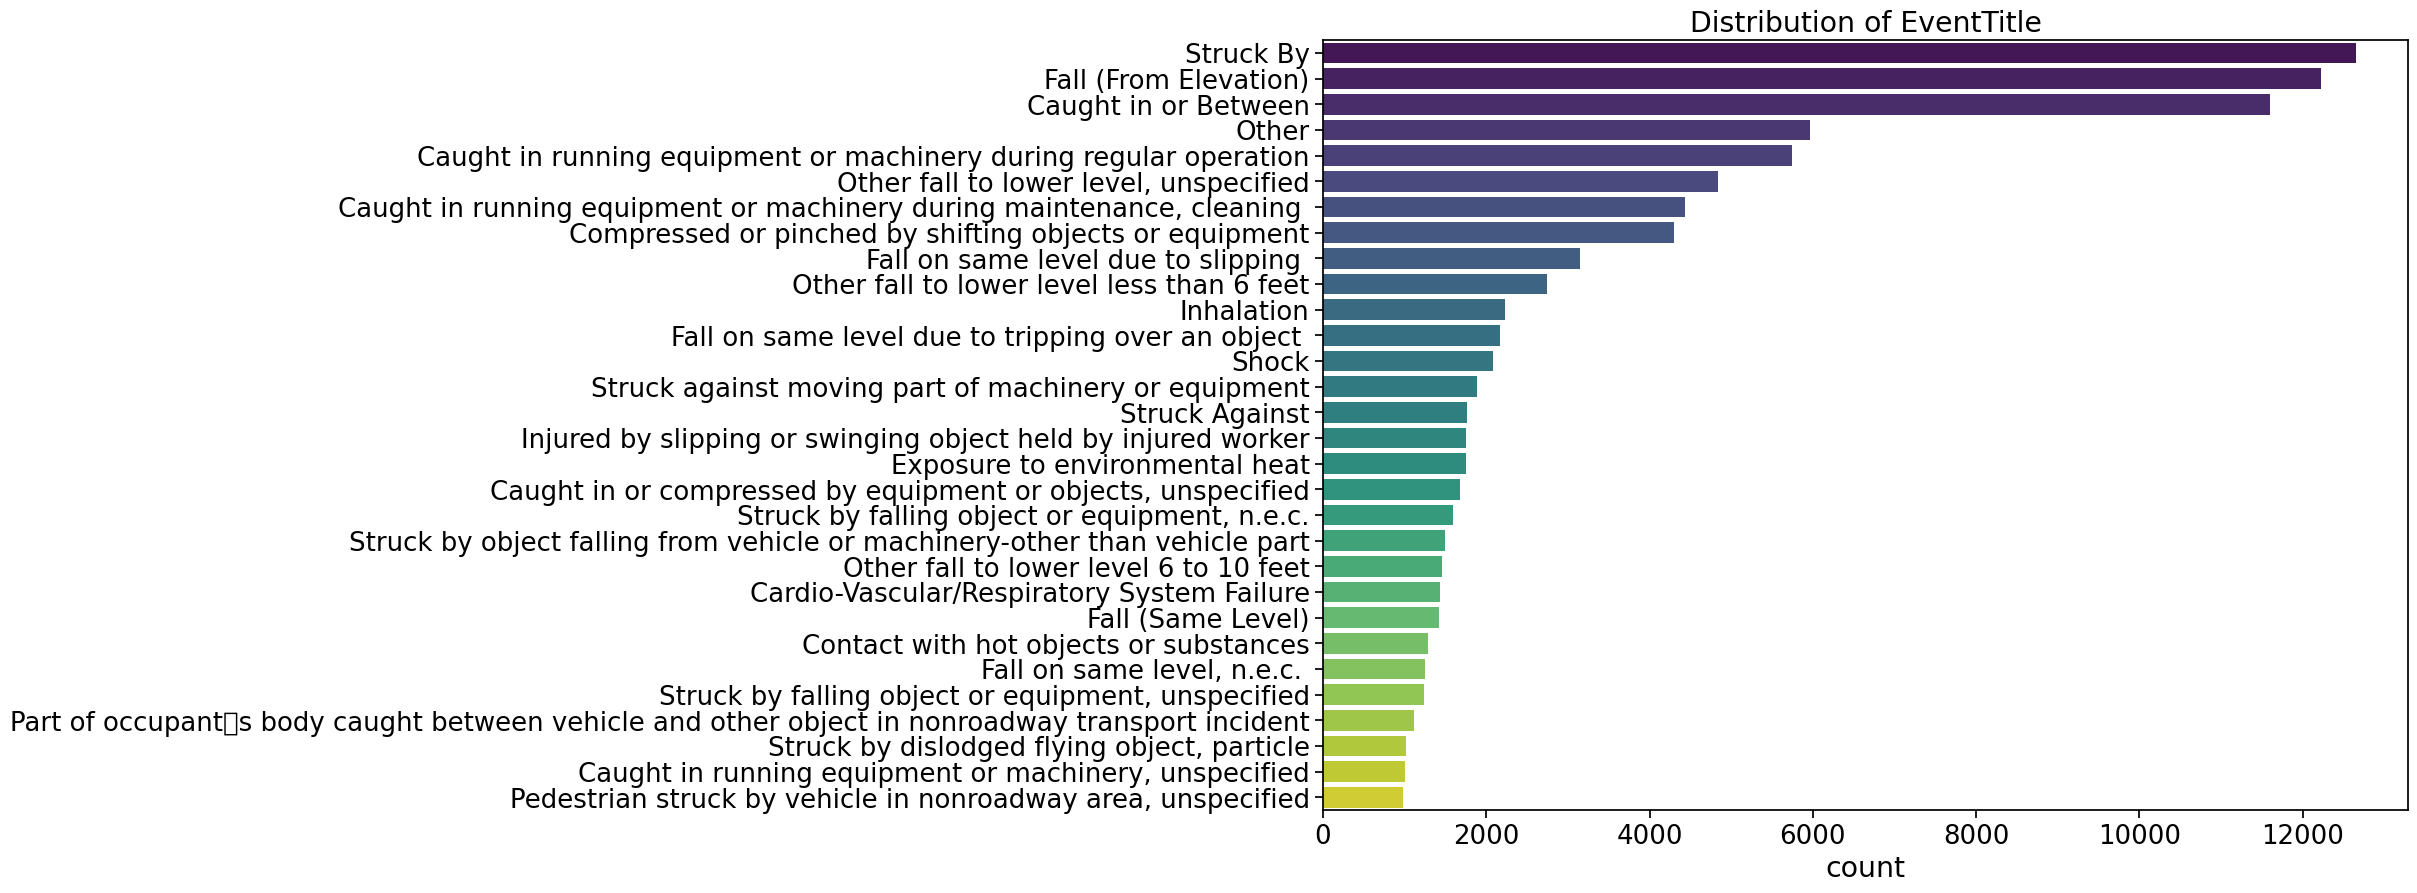

In [11]:
with sns.plotting_context("notebook", font_scale=1.7):
    f, ax = plt.subplots(1,figsize=[14,10])
    x= "EventTitle"
    n=30
    temptop = df[x].value_counts().index[:n]

    sns.countplot(y=df[x][df[x].isin(temptop)], order=temptop, ax=ax, palette="viridis")
    ax.set_title("Distribution of {}".format(x))
    ax.set_ylabel("")
plt.show()

In [12]:
for x in ["EventTitle", "SourceTitle"]:
    print("{} Class Count: {}".format(x,len(set(df[x]))))
    print("{} STD: {}\n".format(x,df[x].value_counts().std()))

EventTitle Class Count: 366
EventTitle STD: 1290.6572878443635

SourceTitle Class Count: 1121
SourceTitle STD: 469.34127177206557



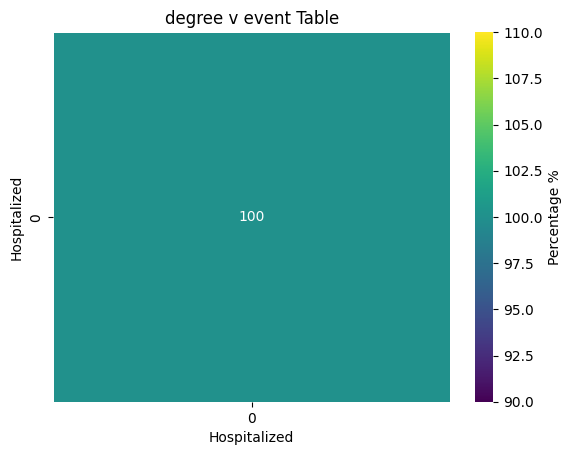

In [13]:
sns.heatmap(pd.crosstab(df['Hospitalized'], df["Hospitalized"], normalize=True).mul(100).round(0),
            annot=True, linewidths=.5,fmt='g', cmap="viridis",
                cbar_kws={'label': 'Percentage %'})
plt.title("degree v event Table")
plt.show()

## TODO: Import collections counter module and use its most common function for this

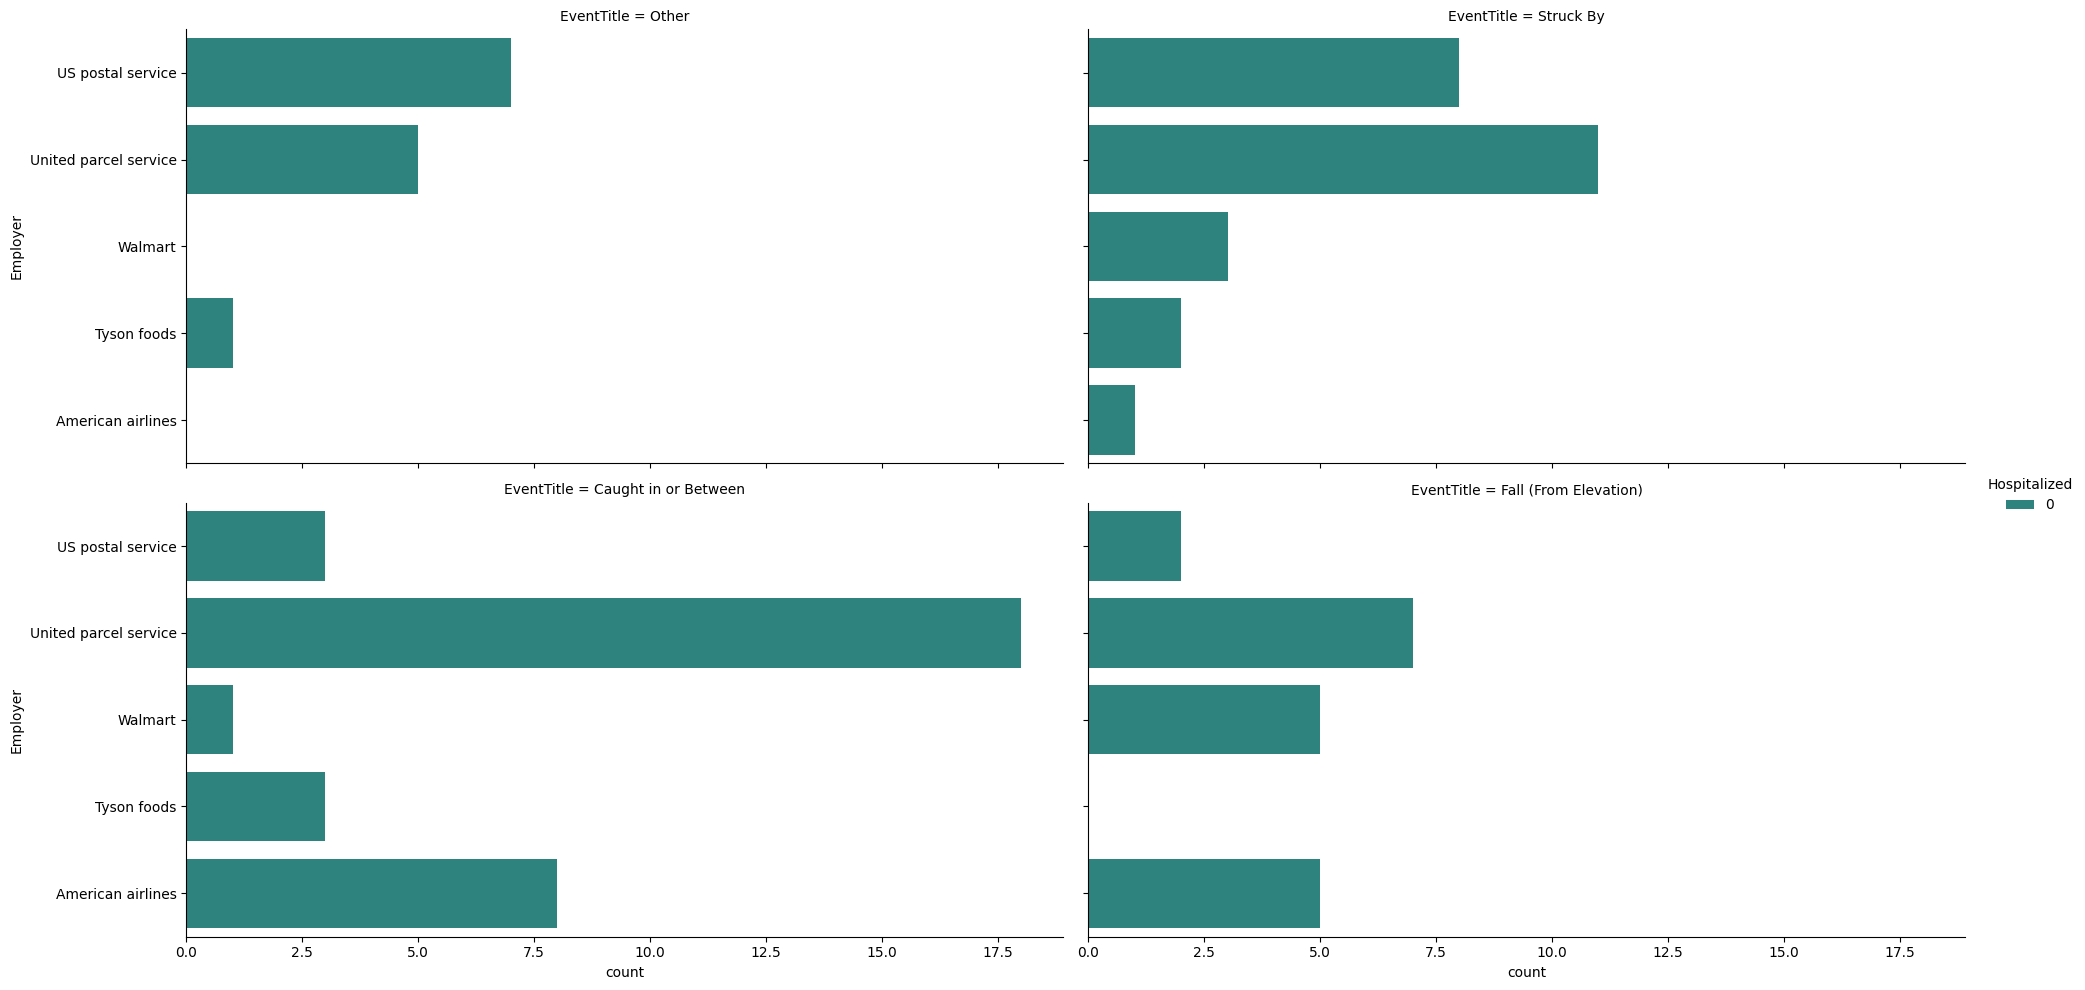

In [14]:
col = "EventTitle"
temp = df.loc[(topcats(df["Employer"]))
              &(topcats(df[col],n=4))
              ,:]
sns.factorplot(y="Employer", hue="Hospitalized", col=col, col_wrap=2,
            data=temp, kind="count", palette='viridis',
               order=df["Employer"].value_counts().index[:5],aspect=2)
plt.show()

Makes me wonder which accidents lead to the most amputations.
***
**Looking at Amputation Rates:** <br>

In [15]:
# def target_rate_by(df, target, by):
#     """
#     So I can look at amputated (target) rate through different lenses (by)
#     """
#     amp_rates = (pd.crosstab(df[by], df[target], normalize = 'index')
#                  .mul(100).round(0).reset_index())
#     amp_rates.columns = [by, "False Rate","Rate"]
#     amp_rates["Count"] = "NaN"
    
#     for x in set(amp_rates[by]):
#         amp_rates.loc[amp_rates[by]==x, "Count"] = df.loc[df[by]==x, by].count()

#     return (amp_rates[[by,"Rate", "Count"]]
#      .sort_values(by="Rate",ascending=False))

# variables = ["EventTitle","SourceTitle","NatureTitle","Part of Body Title",
#              "Employer","State","City","Gender"]
# top = 10
# limit = 7

# # Plot
# f, ax = plt.subplots(len(variables),figsize=[8,25])
# for i,x in enumerate(variables):
#     temp = target_rate_by(df=df, target="Amputated", by=x) # Custom Function
#     sns.barplot(x="Rate",y=x, ax=ax[i],palette='viridis',
#                 data= temp.loc[(temp.Count > limit)][:top])
#     ax[i].set_title("{} Variable".format(x))
#     ax[i].set_xlabel("")
#     ax[i].set_ylabel("")
# ax[len(variables)-1].set_xlabel("Amputation Rate")
# #plt.tight_layout(pad=0)
# plt.subplots_adjust(top=0.95)
# plt.suptitle('Amputation Rate by Categories - Top {} Subclass with Incident Count Over {}'
#              .format(top,limit),fontsize=17)
# plt.show()

In [16]:
def cat_time_slicer(df, slicevar, n, timeframes):
    """
    Function to count observation occurrence through different lenses of time.
    """
    f, ax = plt.subplots(len(timeframes), figsize = [11,7])
    top_classes = topcat_index(df[slicevar],n=n)
    for i,x in enumerate(timeframes):
        for y in top_classes:
            total = df.loc[df[slicevar]==y,slicevar].count()
            ((df.loc[(df[slicevar]==y),[x,"Employer"]]
             .groupby([x])
             .count()/total).fillna(0)
            .plot(ax=ax[i], label=y))
        ax[i].set_ylabel("Percent of\nCompany Incidents")
        ax[i].set_title("Percent of Incident by Company by {}".format(x))
        ax[i].set_xlabel("")
        ax[i].legend(top_classes, fontsize='large', loc='center left',bbox_to_anchor=(1, 0.5))
    ax[len(timeframes)-1].set_xlabel("Time Frame")
    plt.tight_layout(pad=0)
    plt.subplots_adjust(top=0.90)
    plt.suptitle('Normalized Time-Series for top {} {}s over different over {}'.format(n,slicevar,timeframes),fontsize=17)

**By Employer:** <br>

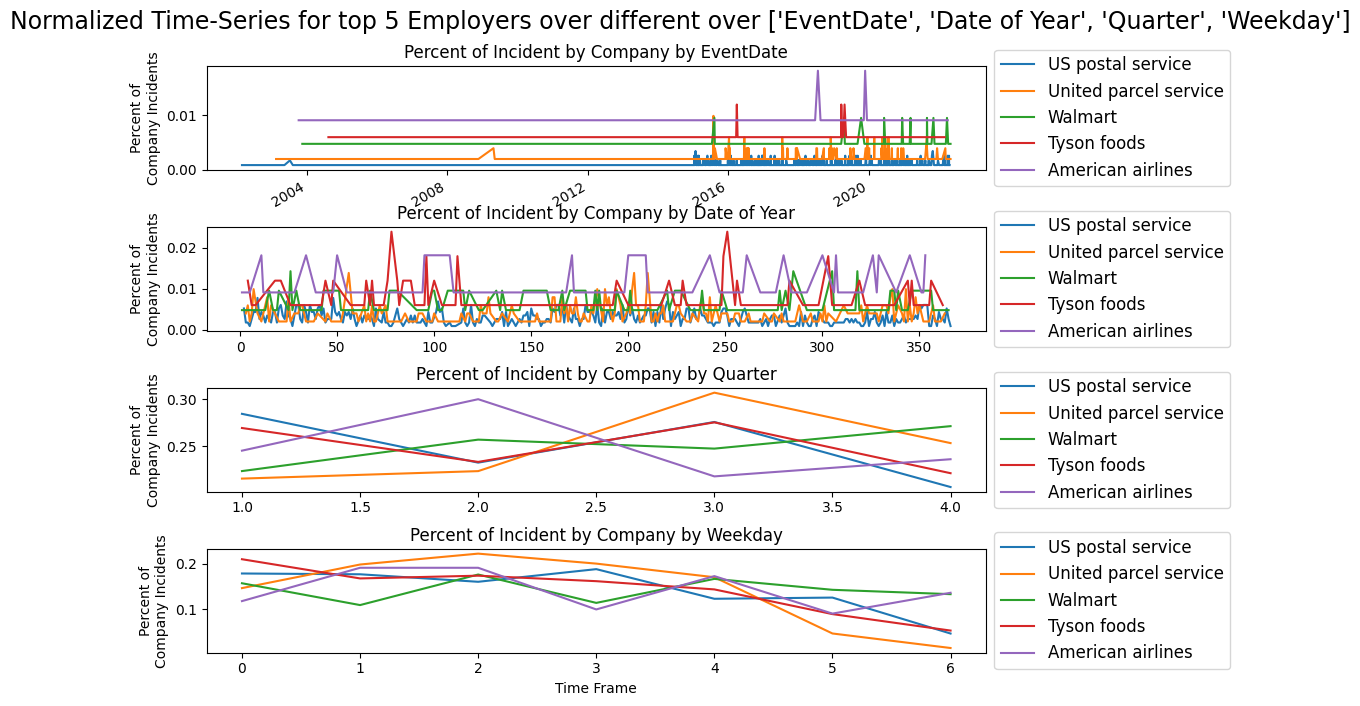

In [17]:
cat_time_slicer(df=df, slicevar = "Employer",
                n=5, timeframes=["EventDate","Date of Year","Quarter","Weekday"])

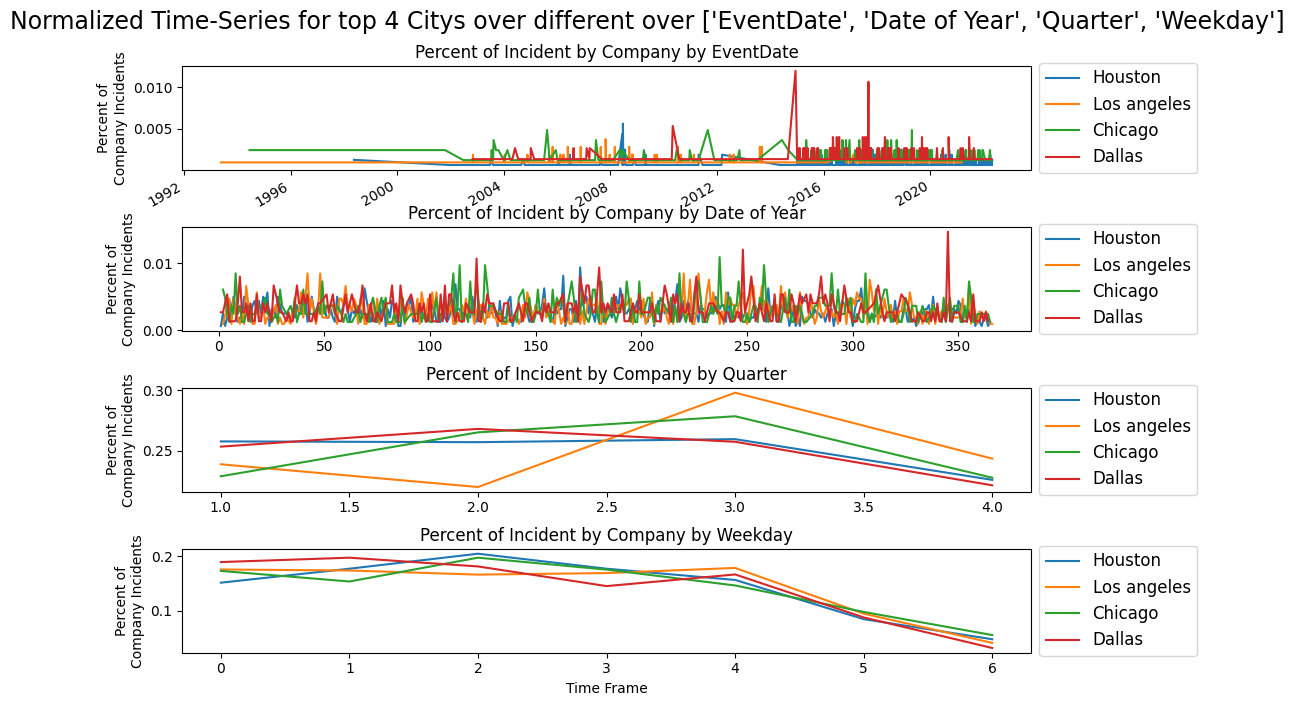

In [18]:
cat_time_slicer(df=df, slicevar = "City",
                n=4, timeframes=["EventDate","Date of Year","Quarter","Weekday"])

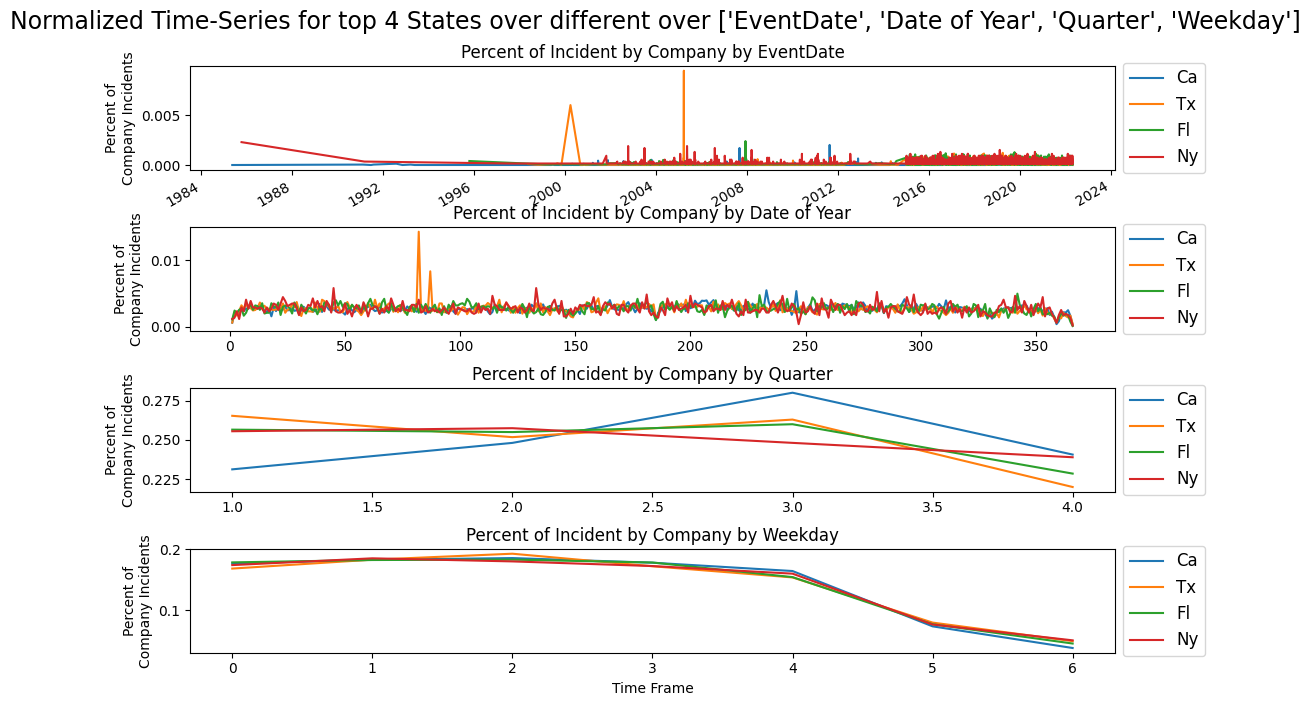

In [19]:
cat_time_slicer(df=df, slicevar = "State",
                n=4, timeframes=["EventDate","Date of Year","Quarter","Weekday"])

**Interpretation:** <br>
More-or-less same behavior over states.

***
**Boolean Amputated:** <br>

In [20]:
# cat_time_slicer(df=df, slicevar = "Amputated",
#                 n=4, timeframes=["EventDate","Date of Year","Quarter","Weekday"])

In [21]:
# cat_time_slicer(df=df[df.Gender != "Both Mentioned"], slicevar = "Gender",
#                 n=5, timeframes=["EventDate","Date of Year","Quarter","Weekday"])

In [22]:
[print("{}\n".format(x)) for x in 
 df["Final Narrative"].loc[
     (df["Hospitalized"]=='Fatal') & 
     (df["Final Narrative"]
      .str.contains(r"(?i)gun|(?i)burn|(?i)shock"))]
 .sample(10)]

ValueError: a must be greater than 0 unless no samples are taken

## Topic Modeling and Word Clouds

Copied my analysis framework from my [Dark Net Illegal Goods Investigation](https://www.kaggle.com/nicapotato/dark-net-light-in-the-dark)

In [ ]:
# Topic Modeling
from nltk import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from wordcloud import WordCloud, STOPWORDS

size = (10,7)
# Function
def cloud(text, title):
    # Processing Text
    stopwords = set(STOPWORDS) # Redundant
    wordcloud = WordCloud(width=800, height=400,
                          #background_color='white',
                          #stopwords=stopwords,
                         ).generate(" ".join(text))
    
    # Output Visualization
    fig = plt.figure(figsize=size, dpi=80, facecolor='k',edgecolor='k')
    plt.imshow(wordcloud,interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=50,color='y')
    plt.tight_layout(pad=0)
    plt.show()

lemm = WordNetLemmatizer()
class LemmaCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(LemmaCountVectorizer, self).build_analyzer()
        return lambda doc: (lemm.lemmatize(w) for w in analyzer(doc))
    
# Define helper function to print top words
def print_top_words(model, feature_names, n_top_words):
    for index, topic in enumerate(model.components_):
        message = "Topic #{}: ".format(index)
        message += " ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1 :-1]])
        print(message)
    
def LDA(data, name=""):
    # Storing the entire training text in a list
    text = list(data.values)
    # Calling our overwritten Count vectorizer
    tf_vectorizer = LemmaCountVectorizer(max_df=0.95, min_df=2,
                                              stop_words='english',
                                              decode_error='ignore')
    tf = tf_vectorizer.fit_transform(text)


    lda = LatentDirichletAllocation(n_components=3, max_iter=10,
                                    learning_method = 'online',
                                    learning_offset = 50.,
                                    random_state = 0)
    lda.fit(tf)

    n_top_words = 10
    print("\n{} Topics in LDA model: ".format(name))
    tf_feature_names = tf_vectorizer.get_feature_names()
    print_top_words(lda, tf_feature_names, n_top_words)
    
# Output
pd.set_option('max_colwidth', 700)
pd.set_option('max_info_columns', 100)

def topic_view(catlevel,x,target="Final Narrative",df=df):
    df = df[df[df[catlevel]==x].notnull()]
    print(LDA(df.loc[df[catlevel]==x,target], name=x))
    cloud(df.loc[df[catlevel]==x,target].values,"{}".format(x))

    return df.loc[df[catlevel]==x,[target,"Amputation"]].sample(4)

In [ ]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to C:\Users\Thomas
[nltk_data]     Tatum\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

**By Employer:** <br>


Caterpillar Topics in LDA model: 
Topic #0: left amputation suffered assembly pinched resulting frame excavator causing engine
Topic #1: engine hospitalization causing frame resulting suffered amputation left excavator pinched
Topic #2: left resulting pinched engine frame causing suffered hospitalization amputation excavator
None


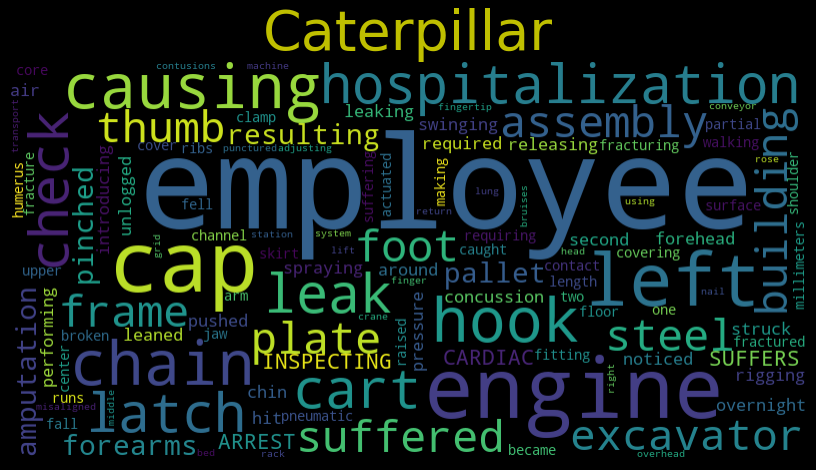

KeyError: "['Amputation'] not in index"

In [ ]:
topic_view(df=df, catlevel="Employer", x="Caterpillar")

In [ ]:
topic_view(df=df, catlevel="Employer", x="Tyson foods")

In [ ]:
topic_view(df=df, catlevel="Employer", x="US postal service")

In [ ]:
topic_view(df=df, catlevel="Employer", x="Walmart")

***
**By Gender:** <br>

In [ ]:
topic_view(df=df, catlevel="Gender", x="Male")

In [ ]:
topic_view(df=df, catlevel="Gender", x="Female")

***
**By Body Part Affected:**

In [ ]:
topic_view(df=df, catlevel="Part of Body Title", x="Brain")

***
Super interesting dataset, I'll probably keep coming back to it. Prayers out to those who get hurt at work, and I hope they were able to bounce back. <br>
For those working dangerous jobs out there.. **BE CAREFUL**

_-Nick_